In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

from fitter import Fitter
import scipy.stats
from scipy.stats import exponnorm, erlang, gennorm

from skmultiflow.drift_detection import PageHinkley
from driftwatch import GreedyKS, IksReservoir, ReservoirSampling, LallDDSketch

In [3]:
# def get_methods(ref_distrib, num_bins, min_instances):
#     ph = PageHinkley(min_instances=min_instances)
#     gks = GreedyKS(dist=ref_distrib, m=num_bins, min_instances=min_instances)#, drift_threshold=0.000001)
#     rs = ReservoirSampling(num_bins, ref_distrib)


#     methods = {
#         "page hinkley" : ph,
#         "greedyKS" : gks,
#         "reservoir sampling" : rs,
        
#     }
#     methods_drifts = {
#     "page hinkley" : [],
#     "greedyKS" : [],
#     "reservoir sampling" : [],

#     }

#     methods_times = {
#         "page hinkley" : 0,
#         "greedyKS" : 0,
#         "reservoir sampling" : 0,

#     }

#     methods_colors = {
#         "page hinkley" : 'r',
#         "greedyKS" : 'g',
#         "reservoir sampling" : 'b',

#     }

#     return methods, methods_drifts, methods_times, methods_colors

In [4]:
def load_data(column):
    stream = []
    days = range(1, 23) # 1, 32
    months = range(1, 2) #1, 3
    for month in months:
        month_2_digits = '{month:02}'.format(month=month)
        path = './COVID19_Tweets_Dataset_2020/Summary_Sentiment/2020_' + month_2_digits + '/'

        for day in days:
            if month == 2 and day > 29:
                continue
            if month == 1 and day < 22:
                continue

            for hour in range(24):
                file_name = path + f'2020_{month_2_digits}_' + '{day:02}'.format(day=day) + '_{hour:02}'.format(hour=hour) + '_Summary_Sentiment.csv'
                stream.append(pd.read_csv(file_name)[column])

    return pd.concat(stream, ignore_index=True), stream

In [ ]:
stream_ln = load_data('Logits_Negative')[0]
stream_lp = load_data('Logits_Positive')[0]
stream_lt, tweets_per_file = load_data('Logits_Neutral')

In [5]:
def get_fitted_ks_values(data):
    f = Fitter(data)
    f.fit()
    return f.summary(plot=False, clf=False)['ks_pvalue'].values

In [9]:
ks_values = []
for tweets_hour in tweets_per_file:
    ks_values.append(get_fitted_ks_values(tweets_hour))
    break

np.mean([i>=.01 for i in np.concatenate(ks_values)])

Fitting 110 distributions:  74%|███████▎  | 81/110 [00:11<00:03,  7.48it/s]SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
Fitting 110 distributions:  97%|█████████▋| 107/110 [00:21<00:01,  1.66it/s]/home/thalis/repositories/TCC/venv/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:  99%|█████████▉| 109/110 [00:29<00:01,  1.77s/it]/home/thalis/re

1.0

In [11]:
np.mean([i>=.01 for i in get_fitted_ks_values(stream_ln)])

Fitting 110 distributions:   2%|▏         | 2/110 [00:30<32:26, 18.02s/it]SKIPPED anglit distribution (taking more than 30 seconds)
SKIPPED arcsine distribution (taking more than 30 seconds)
Fitting 110 distributions:   3%|▎         | 3/110 [00:31<17:35,  9.86s/it]SKIPPED argus distribution (taking more than 30 seconds)
SKIPPED beta distribution (taking more than 30 seconds)
Fitting 110 distributions:   5%|▍         | 5/110 [00:31<07:35,  4.34s/it]SKIPPED betaprime distribution (taking more than 30 seconds)
SKIPPED bradford distribution (taking more than 30 seconds)
Fitting 110 distributions:  11%|█         | 12/110 [01:01<08:01,  4.92s/it]SKIPPED cosine distribution (taking more than 30 seconds)
SKIPPED chi2 distribution (taking more than 30 seconds)
Fitting 110 distributions:  12%|█▏        | 13/110 [01:01<06:07,  3.79s/it]SKIPPED crystalball distribution (taking more than 30 seconds)
SKIPPED dgamma distribution (taking more than 30 seconds)
Fitting 110 distributions:  20%|██        

0.0

/home/thalis/repositories/TCC/venv/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [6]:
def get_file_names():
    files = []
    days = range(1, 23) # 1, 32
    months = range(1, 2) #1, 3
    for month in months:
        month_2_digits = '{month:02}'.format(month=month)
        path = './COVID19_Tweets_Dataset_2020/Summary_Sentiment/2020_' + month_2_digits + '/'

        for day in days:
            if month == 2 and day > 29:
                continue
            if month == 1 and day < 22:
                continue

            for hour in range(24):
                file_name = path + f'2020_{month_2_digits}_' + '{day:02}'.format(day=day) + '_{hour:02}'.format(hour=hour) + '_Summary_Sentiment.csv'
                files.append(file_name)

    return files

In [60]:
def get_dist_obj(dist, param):
    if dist == 'gamma':
        return scipy.stats.gamma(**param)
    if dist == 'rayleigh':
        return scipy.stats.rayleigh(**param)
    if dist == 'uniform':
        return scipy.stats.uniform(**param)

In [ ]:
methods, methods_drifts, methods_times, methods_colors = get_methods(distribution, num_bins=10**3, min_instances=0)
         
for m in methods:
    start = time.time()
    for i, x in enumerate(stream_ln):
        methods[m].add_element(x)
        if methods[m].detected_change():
            methods_drifts[m].append(i)
            methods[m].reset()
    methods_times[m] = methods_times[m] + time.time() - start

print('Number of tweets processed: ', len(stream_ln))

In [68]:
def rs_builder(ref_distrib, num_bins):
    return ReservoirSampling(num_bins, ref_distrib)

def gks_builder(ref_distrib, num_bins):
    return GreedyKS(ref_distrib, num_bins, exact_prob=True)

# def dds_builder(ref_distrib, num_bins, stream):
#     return LallDDSketch(compute_ddsketch_error(stream, num_bins), ref_distrib)

# def iks_builder(ref_distrib, num_bins, stream):
#     return IksReservoir(num_bins, ref_distrib)

method_factory = {
    'Reservoir Sampling': rs_builder,
    'GreedyKS': gks_builder,
    # 'Lall + DDSketch': dds_builder,
    # 'IKS + RS': iks_builder,
}

methods = ['GreedyKS', 'Reservoir Sampling']#, 'IKS + RS', 'Lall + DDSketch']

In [76]:
def run(num_bins):
    files = get_file_names()
    instances_methods = {}
    time = 0
    methods_drifts = {
        "page hinkley" : [],
        "GreedyKS" : [],
        "Reservoir Sampling" : [],
    }

    for file in files:

        sample = pd.read_csv(file)['Logits_Negative']

        f = Fitter(sample, distributions=["gamma", "rayleigh", "uniform"])
        f.fit()
        best_fitted = f.get_best()
        dist = get_dist_obj(list(best_fitted.keys())[0], list(best_fitted.values())[0])
        
        for element in sample:
            time += 1
            for m in methods:
                if m in instances_methods:
                    instances_methods[m].add_element(element)
                    if instances_methods[m].detected_change():
                        methods_drifts[m].append(time)
                        del instances_methods[m]

        for m in methods:
            if m not in instances_methods:
                instances_methods[m] = method_factory[m](dist, num_bins)
                for element in sample:
                    # print(methods)
                    # print(m)
                    instances_methods[m].add_element(element)

    return methods_drifts
        



In [77]:
run(100)

Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00, 28.37it/s]


{'page hinkley': [],
 'GreedyKS': [273,
  576,
  716,
  986,
  1259,
  1763,
  2227,
  2864,
  3833,
  4854,
  6081,
  7539,
  9450,
  11357,
  13237,
  16408,
  20827,
  25502,
  29323,
  32833],
 'Reservoir Sampling': [2256, 14613, 17256, 24679, 25871]}

In [19]:
# distribution = exponnorm(5.025553216466441, loc=-1.1327249541070226, scale=0.2032867510140243)
distribution = gennorm(*f_neg.fitted_param['gennorm'])

methods, methods_drifts, methods_times, methods_colors = get_methods(distribution, num_bins=10**3, min_instances=0)
         
for m in methods:
    start = time.time()
    for i, x in enumerate(stream_ln):
        methods[m].add_element(x)
        if methods[m].detected_change():
            methods_drifts[m].append(i)
            methods[m].reset()
    methods_times[m] = methods_times[m] + time.time() - start

print('Number of tweets processed: ', len(stream_ln))

KeyboardInterrupt: 

In [ ]:
methods_times

{'page hinkley': 0.25894808769226074,
 'greedyKS': 64.47171211242676,
 'reservoir sampling': 519.1544232368469}

In [11]:
print('Reservoir S ', len(methods_drifts['reservoir sampling']))
print('GreedyKS ', len(methods_drifts['greedyKS']))
print('Page hinkley ', len(methods_drifts['page hinkley']))


Reservoir S  9793
GreedyKS  9769
Page hinkley  14


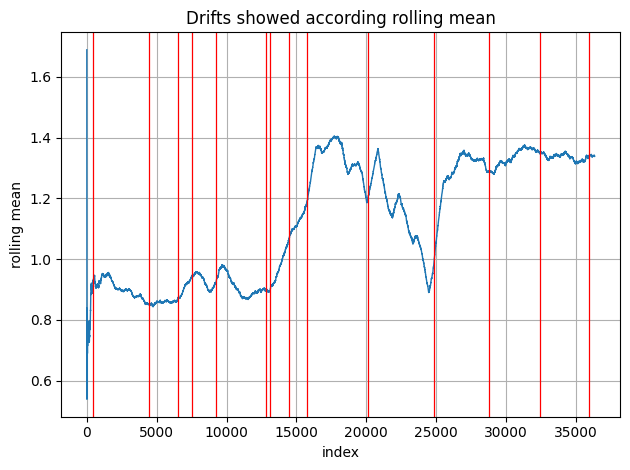

In [13]:
rolling_mean = stream_ln.rolling(len(stream_ln)//10, min_periods=0).mean()

# plt.figure(figsize=(5,3.5))
plt.plot(rolling_mean, linewidth=1)

for m in methods_drifts:
    if m != 'page hinkley':
        continue
    for d in methods_drifts[m]:
        plt.axvline(x = d, color = methods_colors[m], linewidth=0.9, label=m)




plt.title('Drifts showed according rolling mean')
# plt.legend()
plt.xlabel('index')
plt.ylabel('rolling mean')
plt.grid(True)
plt.tight_layout()
plt.show()